# Introduction to phylogenetic comparative methods in R
Goettingen 2023  
Andrew Hipp, ahipp@mortonarb.org  
Tutorial 03b: Stretching the tree and manipulating   
Use [static view in nbviewer](https://nbviewer.org/github/andrew-hipp/workshops/blob/master/2023-goettingen/Wk3-EvolutionaryProcess/03b.treeStretching.ipynb) if you are not working directly in Jupyter notebooks.

# Session 3b: Evaluating alternative evolutionary models

## Comparing a one-rate model with a two-rate model

Let's start with the example of a very simple censored two-rate model as we discussed in lecture. First let's generate a tree and some data under a single rate:

In [7]:
library(geiger)
tr <- sim.bdtree(n = 20)
dat <- sim.char(tr, 1, 1)

then let's transform that tree and simulate a second dataset that has two rates:

In [8]:
tr2 <- ex.ratesimulator(tr, min = 5)
dat2 <- sim.char(tr2,1,1)

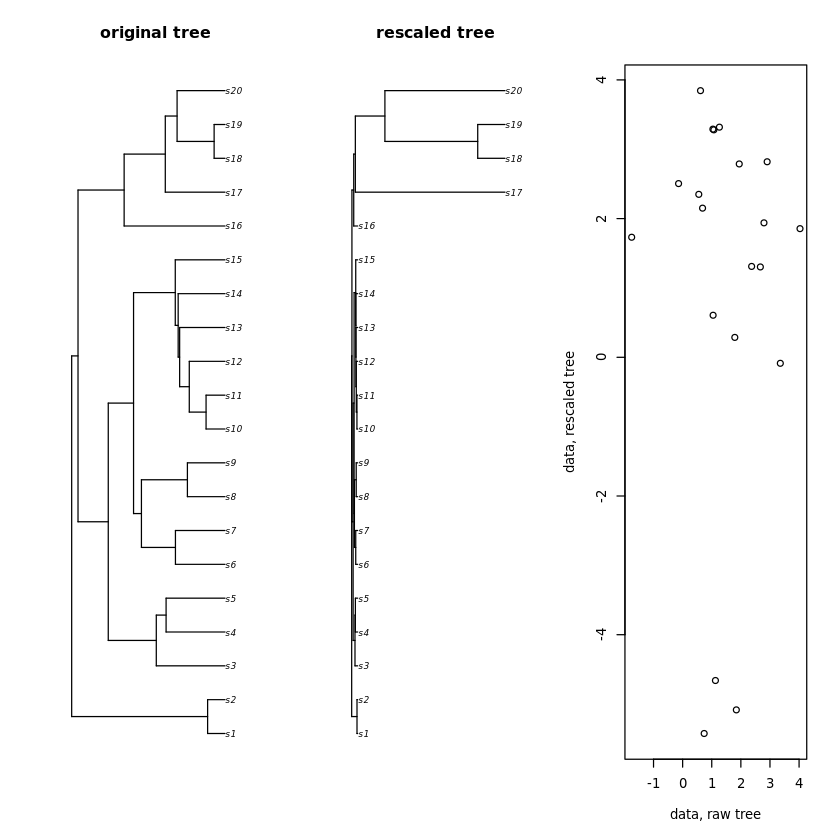

In [9]:
layout(matrix(1:3, 1))
plot(tr, main = 'original tree')
plot(tr2, main = 'rescaled tree')
plot(dat[,,1], dat2[,,1], xlab = 'data, raw tree', ylab = 'data, rescaled tree', main = '')

Okay. We can use the `geiger` package to estimate the Brownian motion model parameters on these for the single-rate model:

In [18]:
models <- list(
    origOnOrig = fitContinuous(tr, dat[,,1]),
    origOnRescaled = fitContinuous(tr2, dat[,,1]),
    rescaledOnRescaled = fitContinuous(tr2, dat2[,,1]),
    rescaledOnOrig = fitContinuous(tr,dat2[,,1])
)
models.mat <- cbind(orig = models$origOnOrig$opt,
                    origOnRescaled = models$origOnRescaled$opt,
                    rescaled = models$rescaledOnRescaled$opt,
                    rescaledOnOrig = models$rescaledOnOrig$opt)
print(models.mat)

       orig      origOnRescaled rescaled   rescaledOnOrig
sigsq  0.6059365 0.4110369      0.9347183  36.67031      
z0     1.777819  1.745502       -0.2267405 -0.3184276    
lnL    -21.54245 -31.98374      -40.19936  -62.57193     
method "Brent"   "Brent"        "Brent"    "Brent"       
k      2         2              2          2             
aic    47.08491  67.96749       84.39873   129.1439      
aicc   47.79079  68.67337       85.10461   129.8497      


Now, let's simulate data on each tree under a Brownian motion model. Ordinarily you should do 200--1000 simulations, but we'll just do a few so that this runs quickly. We'll simulate all four data-tree combinations, using the ML estimates of the root and $\sigma^2$. The model names will be abbreviated with two numbers, where the first number indicates the dataset, the second the model (the tree):

In [19]:
sims <- list(
    s12 = sim.char(tr2, par = as.numeric(models.mat['sigsq', 'origOnRescaled']), root = as.numeric(models.mat['z0', 'origOnRescaled']), nsim = 20),
    s11 = sim.char(tr, par = as.numeric(models.mat['sigsq', 'orig']), root = as.numeric(models.mat['z0', 'orig']), nsim = 20),
    s22 = sim.char(tr2, par = as.numeric(models.mat['sigsq', 'rescaled']), root = as.numeric(models.mat['z0', 'rescaled']), nsim = 20),
    s21 = sim.char(tr, par = as.numeric(models.mat['sigsq', 'rescaledOnOrig']), root = as.numeric(models.mat['z0', 'rescaledOnOrig']), nsim = 20)
)
sims.out <- sapply(names(sims), function(x) {
    if(substr(x,3,3) == 2) simTree <- tr2
        else simTree <- tr
    out <- apply(sims[[x]], 3, function(y) fitContinuous(simTree, y)$opt$lnL)
    out
        })
sims.out

s12,s11,s22,s21
-31.98592,-23.26334,-32.52162,-63.54753
-24.42027,-18.40896,-28.64504,-60.28272
-33.92945,-22.60903,-40.66951,-62.16665
-30.52479,-18.65091,-35.42241,-61.93158
-34.85438,-24.76764,-37.33863,-62.95710
-35.73557,-20.21571,-40.79143,-64.51090
-29.59141,-19.90138,-37.28263,-56.19989
-26.06640,-17.86840,-40.02099,-62.05684
-34.43232,-23.76491,-39.52019,-67.87239
-27.39197,-24.60958,-41.06547,-58.49303


Now, it is to you to figure out how well your data fit. Use the likelihood ratio $-2 (lnL_{model1} - lnL_{model2})$ as your test statistic, and compare the observed to the distribution.

# Tutorial questions, Tree stretching
We have covered most of the basics of tree stretching in lecture. Work on the following four challenge questions. You are welcome to pilfer code from the lectures, but try (especially in questions 1 and 4) to work directly from the literature. Sometimes methods published in the literature do not have a packaged software implementation, and sometimes even when there is one it is cumbersome to use, either in its own rights or because it does not work well with your workflow. O'Meara et al. 2006 and Blomberg et al. 2003 are a good place to start learning to implmenet methods.

1. Code the GLS estimators that O'Meara et al. (2006) use to estimate the rate of trait evolution. Use separate functions for each of the following:
    * The phylogenetic mean (or ancestral state at the root)
    * Sigma-squared (the rate)
    * The log-likelihood

2. Make a tree. Generate data using the ```sim.char``` function on the original tree and the tree rescaled to ```lambda = 0.5```. Plot the log-likelihood of your data from lambda = 0 to lambda = 0.5. Using a lnL level of 2 as your significance level, visualize the confidence you should have in your point estimate. Try the same exercise with several trees of 20 taxa and several of 50 taxa. How does your power to detect a lambda < 1 vary with sample size?  

3. Code a function to perform the censored test of O'Meara et al. Your function should take a tree, some definition of how the tree should be split up into groups, and a vector of data. These are the arguments of your function. The value of your function (what it returns) should include the log-likelihood of the model, the root state, and sigma-squared for each subtree.

4. Code the GLS version of Blomberg's ```K``` (hint: use the formulas in the text _and_ Appendix 2 from Blomberg et al. 2003).

# Challenge questions to pursue on your own
1. Use the ```rescale``` function from ```geiger``` to investigate the effects of Pagel's lambda, delta, and kappa on a tree. Compare the "lambda" model to the "OU" model. 

2. Use the ```pmc``` model to do Boettiger et al.'s (2012) bootstrapping approach. Work through the vignette:

```
library(pmc)
vignette('pmc_tutorial')
```

3. Code O'Meara et al.'s expected disparity statistic; you can disregard the sigma-squared at the beginning for this exercise. What do the terms of ```E(disparity)``` mean? Make one tree, and scale it from no phylogenetic signal (e.g., ```rescale(tr, 'lambda', 0)```) to very high phylogenetic signal (e.g., ```rescale(tr, 'delta', 0.01)```). How do these rescalings affect ```E(disparity)``` on a given tree? 

# Tutorial question help -- Try before you peek!
Below are possible ways of approaching the tutorial questions. Use these hints if you get stuck, or compare your results to these to see whether your approach converges on mine.

### Question 1: phylogenetic rate

In [3]:
library(ape)

rootState <- function(tr, X) {
  ## the maximum likelihood estimate of root state based on O'Meara, p. 925
  vcvMat <- vcv(tr)
  one <- matrix(1, length(X), 1) # a matrix of 1s, as tall as the length of X
  B0 <- as.numeric(solve(t(one) %*% solve(vcvMat) %*% one) %*% (t(one) %*% solve(vcvMat) %*% X))
  return(B0)
  }

sigmaSq <- function(tr, X) {
  ## following O'Meara 2006, eq. 2
  vcvMat <- vcv(tr)
  N <- length(X)
  E.X <- matrix(rootState(tr, X), length(X), 1) # expected value of X is just the rootstate of X
  sigmaSq <- as.numeric((t(X - E.X) %*% solve(vcvMat) %*% (X - E.X)) / N)
  out <- list(V = vcvMat * sigmaSq, sigmaSq = sigmaSq, X = X, E.X. = E.X, N = N)
  class(out) <- "phylogSigmaSq"
  return(out)
  }

logLik.phylogSigmaSq <- function(object, ...) {
    # following O'Meara 2006, eq. 3
    # takes output from sigmaSq
numer <- exp(-0.5 * t(object$X - object$E.X) %*% solve(object$V) %*% (object$X - object$E.X))
  denom <- sqrt((2*pi)^object$N * det(object$V))
  out <- log(numer / denom)
  attr(out, "nobs") <- object$N
  attr(out, "df") <- 2
  class(out) <- "logLik"
  return(out)
  }

#### Question 2 : likelihood surface

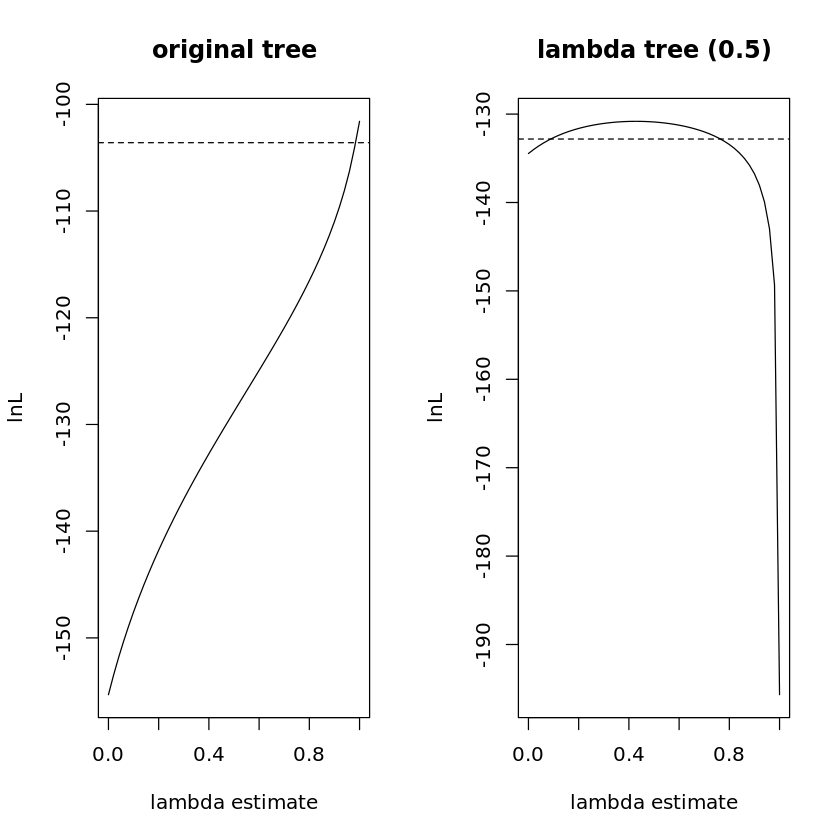

In [4]:
library(geiger)
library(phytools)

tr3 <- pbtree(n = 70)
x.raw <- sim.char(tr3, 1)[,,]
x.lambda.5 <- sim.char(rescale(tr3, 'lambda', 0.5), 1)[,,]
par(mfrow=c(1,2))
x.vals <- seq(from = 0, to = 1, by = 0.02)
y.raw <- sapply(x.vals, function(w) {
    tr.temp <- rescale(tr3, 'lambda', w)
    logLik.phylogSigmaSq(sigmaSq(tr.temp, x.raw))
    }
    )
y.lambda <- sapply(x.vals, function(w) {
    tr.temp <- rescale(tr3, 'lambda', w)
    logLik.phylogSigmaSq(sigmaSq(tr.temp, x.lambda.5))
    }
    )

plot(x.vals, y.raw, main = 'original tree', xlab = 'lambda estimate', ylab = 'lnL', type = 'l')
abline(h = max(y.raw)-2, lty = 'dashed')
plot(x.vals, y.lambda, main = 'lambda tree (0.5)', xlab = 'lambda estimate', ylab = 'lnL', type = 'l')
abline(h = max(y.lambda)-2, lty = 'dashed')

##### Question 3 : the censored test
There are lots of ways to implement this. I've written here a sort of sampler function that shows how I would approach the problem... compare it to how you approached the problem, and take what what you like, leave what you don't.

In [5]:
censor <- function(tr, taxa = 2) {
  ## tr is a tree of class "phylo"
  ## taxa is a list of taxa defining subtrees, or a single number for the number of subtrees you'd like to define somewhat interactively
  if(class(taxa) == "numeric" && length(taxa) == 1) {
    taxa <- vector("list", taxa)
    for(i in seq(length(taxa))) taxa[[i]] <- select.list(tr$tip.label, multiple = TRUE, title = "Select taxa comprising one subtree")
    }
  if(!identical(sort(unlist(taxa)), sort(tr$tip.label))) warning("Taxa do not represent non-overlapping sets of taxa on the tree")
  treeList <- vector("list",length(taxa))
  for(i in seq(length(taxa))) {
    tipsToDrop <- tr$tip.label[-which(tr$tip.label %in% taxa[[i]])]
    treeList[[i]] <- drop.tip(tr, tipsToDrop)
    }
  return(treeList)
  }

testModels <- function(tr, X, multiRateModels = 1, modelList = NULL, ...) {
  ## tests a single-rate model against a single multiple-rate models
    # -- should be generalized to compare the single-rate model against as many multiple-rate models as you like
  ## currently only the censored option is implemented
  ## Arguments:
  ##  tr = tree of class "phylo"
  ##  X = vector of trait values
  ##  multiRateModels = number of multiple-rate models to test
  ##  modelList = list of list of trees; if NULL, trees are created interactively using censor function
   
  ## 1. Check the data out a bit to catch obvious problems
  vcvMat <- vcv(tr)
  if(length(X) != dim(vcvMat)[1]) stop("This function currently only takes vectors of trait values equal in length to the number of taxa in the tree")
  if(identical(names(X), NULL)) {
    warning("X has no labels; assumed to be ordered the same as VCV matrix")
    names(X) <- dimnames(vcvMat)[[1]]
    }
  else {
    if(!all(names(X) %in% dimnames(vcvMat)[[1]])) warning("X labels not identical to tip labels; traits assumed to be ordered the same as VCV matrix")
    vcvMat <- vcvMat[names(X), names(X)]
    }
  
  ## 2. Set up the models
  treeSets <- vector("list", 1 + multiRateModels)
  treeSets[[1]] <- list(tr) ## necessary to make this a list of length=1 so that the nested loop below works
  maxTrees <- 1
  for(i in 2:(1 + multiRateModels)) {
    if(class(modelList) == 'list') {
      taxa <- length(modelList[[i]])
      treeSets[[i]] <- modelList[[i]] # use trees if provided, or ...
      } ## close if
    else {
      taxa <- as.numeric(select.list(c('2','3','4','5','6','7','8','9','10'), preselect = "2", title = "Select the number of subtrees you would like"))
      treeSets[[i]] <- censor(tr, taxa) # ... do interactive tree creation if no trees are handed in via modelList
      } ## close else
    maxTrees <- max(taxa, maxTrees)
    } ## close i
  
  ## 3. Set up matrix to capture output
  paramsBase <- c("sigma.sq", "root")
  params <- paste(sort(rep(paramsBase, maxTrees)), rep(1:maxTrees,length(paramsBase)), sep = ".")
  results <- matrix(NA, nrow = length(treeSets), ncol = 2 + length(paramsBase)*maxTrees, dimnames = list(1:length(treeSets), c('lnL', 'df', params)))
  for(i in 1:length(treeSets)) {
    results[i, c('lnL', 'df')] <- c(0,0)
    for(j in 1:length(treeSets[[i]])) {
      tr.temp <- treeSets[[i]][[j]]
      sigma.sq.temp <- sigmaSq(vcv(tr.temp), X[tr.temp$tip.label])
      lnL.temp <- logLik(sigma.sq.temp)
      results[i, c('lnL', 'df')] <- results[i, c('lnL', 'df')] + c(lnL.temp, attr(lnL.temp, 'df'))
      results[i, paste(paramsBase, j, sep = ".")] <- c(sigma.sq.temp$sigmaSq,                         ## sigma.sq
                                                       rootState(vcv(tr.temp), X[tr.temp$tip.label])  ## root
                                                       )                                              ## and close that concatenation
    } ## close j
  } ## close i
  results <- list(treeSets = treeSets, modelSummary = results)
  return(results)
  }

In [10]:
rjRun <- rjmcmc.bm(multi2di(tr), dat2[,,1], filebase = 'jumpTrial') # running with default 20,000 generations

Warning message in .geigerwarn(immediate. = TRUE):
“the called function is currently in development and is not fully vetted”


|                   GENERATIONS COMPLETE                   | 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

                      SAMPLING SUMMARY 
                  proposed        accepted       adoptrate
mergesplit            9675              54          0.0056
rootstate             1252             735          0.5871
ratetune               962             838          0.8711
moveshift              915             364          0.3978
ratescale             8284            8172          0.9865
movejump              9391             887          0.0945
incjump               4880             507          0.1039
decjump               4590             506          0.1102
jumpvar               8300            7945          0.9572
SE                    1751             965          0.5511




,branch,jump.probability,jump.counts
,<int>,<dbl>,<dbl>
edc30f64126263e13e3cf65edb0d8fd1,22,0.002666667,1
1cb668b0b4e308bf912f51259cb94dc5,1,0.010666667,1
bff1537d555fb58aed2f3060f331de5a,2,0.005333333,1
c50ea83675169ae609e1d660d446b761,23,0.002666667,1
f666594ca1c3c03b3fe7228327d1205d,24,0.002666667,1
219b5fad16c8c20d4fe6ba3546eabb47,25,0.008000000,1
423f7aacfe80269592d0ff45a45f3036,3,0.000000000,0
19ef93e00e1a208155c308b40189a69a,26,0.008000000,1
876dcf227226c96acc3bcf507e8a5449,4,0.000000000,0


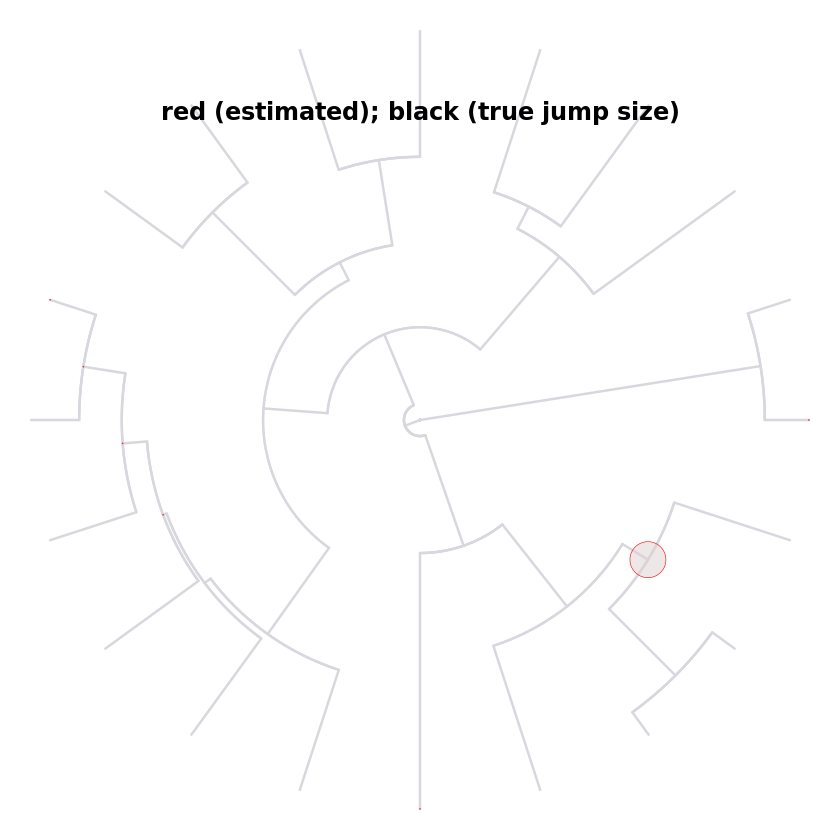

In [11]:
library(geiger)
dirBase = 'jump-relaxedBM.jumpTrial'
ps = load.rjmcmc(dirBase)
defpar <- par(no.readonly=TRUE)

hist <- tr2$hist
plot(x=ps, par="jumps", burnin=0.25, legend=FALSE, show.tip=FALSE, type="fan", edge.width=2)
mm=match(tr$edge[,2],hist$descendant)
hist=hist[mm,]
edgelabels.auteur(text=NULL, pch=21, cex=hist$cex, bg=NA, col=ifelse(hist$cex>0, 1, NA), lty=2)
title("red (estimated); black (true jump size)", line=-5)
par(defpar)

In [ ]:
output$modelSummary <- cbind(
    aic = aic(output$modelSummary[, 1], output$modelSummary[, 2]),
    aic_w = aic.w(aic(output$modelSummary[, 1], output$modelSummary[, 2])),
    output$modelSummary
    )
output$modelSummary

,aic,aic_w,aic,aic_w,lnL,df,root.1,root.2,root.3,sigma.sq.1,sigma.sq.2,sigma.sq.3
1,-220.1352,7.392749e-01,110.06770,9.716599e-05,-53.03385,2,2.914906,NA,NA,17.6171957,NA,NA
2,-181.9746,3.822383e-09,91.86056,8.732624e-01,-41.93028,4,5.984394,1.970260,NA,32.2184634,1.174022,NA
3,-218.0508,2.607248e-01,109.02556,1.636107e-04,-50.51278,4,2.738618,2.923877,NA,0.9417767,20.562152,NA
4,-191.1969,3.845266e-07,95.72491,1.264769e-01,-41.86245,6,2.738618,5.984394,1.663861,0.9417767,32.218463,1.083276


In [ ]:
load('../phyloLive//tutorial.01/data/phylo.session01b.Rdata')
ls()
dim(dat.bio.means)
tr
fitContinuous(tr, dat.bio.means[, 'bio4']) |> print()

[1] "babyTree"             "censor"               "d.a"                 
 [4] "d.L"                  "d.s"                  "dat.bio"             
 [7] "dat.bio.bySp"         "dat.bio.means"        "dat.bio.sem"         
[10] "dat.geog"             "dat.geog.cat"         "dat.lf"              
[13] "dat.pca"              "dat.sect.colors"      "dat.sect.colVect"    
[16] "dat.sect.desc"        "dat.sect.edges"       "dat.sect.mrca"       
[19] "dat.sect.vector"      "dat.sections"         "dat2"                
[22] "fastCladeTips"        "i"                    "lL"                  
[25] "lL.phylogSigmaSq"     "logLik.phylogSigmaSq" "models"              
[28] "models.mat"           "numCols"              "p"                   
[31] "p1"                   "p2"                   "path"                
[34] "pc.dat"               "pp"                   "rootState"           
[37] "sigmaSq"              "spp.intersect"        "temp.na"             
[40] "temp.sd"              "tips"                 "tr"                  
[43] "tr2"                  "treesOut"             "trType"

[1] 133  21


Phylogenetic tree with 133 tips and 132 internal nodes.

Tip labels:
  Quercus_turbinella, Quercus_ajoensis, Quercus_toumeyi, Quercus_grisea, Quercus_oblongifolia, Quercus_engelmannii, ...

Rooted; includes branch lengths.

GEIGER-fitted comparative model of continuous data
 fitted ‘BM’ model parameters:
	sigsq = 170028.695215
	z0 = 5341.755163

 model summary:
	log-likelihood = -1172.711316
	AIC = 2349.422632
	AICc = 2349.514939
	free parameters = 2

Convergence diagnostics:
	optimization iterations = 100
	failed iterations = 0
	number of iterations with same best fit = 100
	frequency of best fit = 1.000

 object summary:
	'lik' -- likelihood function
	'bnd' -- bounds for likelihood search
	'res' -- optimization iteration summary
	'opt' -- maximum likelihood parameter estimates


# 2. Using two existing tools to do the same thing


In [ ]:
rjRun <- rjmcmc.bm(multi2di(tr), dat2[,,1], filebase = 'jumpTrial') # running with default 20,000 generations

In [ ]:
library(geiger)
dirBase = 'jump-relaxedBM.jumpTrial'
ps = load.rjmcmc(dirBase)
defpar <- par(no.readonly=TRUE)

hist <- tr2$hist
plot(x=ps, par="jumps", burnin=0.25, legend=FALSE, show.tip=FALSE, type="fan", edge.width=2)
mm=match(tr$edge[,2],hist$descendant)
hist=hist[mm,]
edgelabels.auteur(text=NULL, pch=21, cex=hist$cex, bg=NA, col=ifelse(hist$cex>0, 1, NA), lty=2)
title("red (estimated); black (true jump size)", line=-5)
par(defpar)